In [1]:
debugDict = {
    'ModSchema': ['QAM','QAM','PSK','PSK'],
    'pulseShaping': ['rrc','square','rrc','square'],
    'txAmp': [40,40,40,40],
    'rxAmp': [20,20,20,20],
    'BER': [0.495,0.59,0.45,0.5545]
}

In [2]:
def plotBaseBandData(data,symbol,rxSymbol=[]):
    colors = np.zeros(len(data))
    if len(rxSymbol)>0:
        figure, axis = ploot.subplots(1, 2)
        for i in range(len(rxSymbol)):
            colors[i] = rxSymbol[i]/4
        axis[1].scatter(data.real,data.imag,c=colors)
        for i in range(len(symbol)):
            colors[i] = symbol[i]/4
        axis[0].scatter(data.real,data.imag,c=colors)
        ploot.show()
    else:
        for i in range(len(symbol)):
            colors[i] = symbol[i]/4
        ploot.scatter(data.real,data.imag,c=colors)
def Convolve(data1,data2):
    ans = np.zeros(len(data1),dtype=type(data1[0]))
    for i in range(0,len(data1)):
        for j in range(0,len(data2)):
            if i-j >=0:
                ans[i] = ans[i] + data1[i-j]*data2[j]
    return ans
def getSNRvsBER(snrMin,snrMax,step):
    snr = np.linspace(snrMin,snrMax,step)
    ber = np.zeros(len(snr))
    for i in range(len(snr)):
        rxAmpDB = 20
        pbRx = np.convolve(pb,ir)
        pbRx = pbRx[0:len(pb)]
        pbRx = comm.awgn(pbRx,snr[i])
        pbRx = pbRx * (10**(rxAmpDB//20))
        bbRx = comm.downconvert(pbRx, int(samplingRate/symbolRate),carrierFreq,samplingRate)
        rxSymbols = comm.demodulate(bbRx,psk)
        ber[i] = comm.ber(comm.sym2bi(rxSymbols,m),comm.sym2bi(symbols,m))
    fig, ax = ploot.subplots(1, 1, figsize=(4, 4), layout='constrained')
    ax.set_xlabel('SNR')
    ax.set_ylabel('BER')
    ax.set_ylim(0,1)
    ax.set_xscale('log')
    ax.plot(snr,ber,'x',ls='-')
    return
def getBeamPattern(dictofDegree):
    ptrn = np.zeros((37,2))
    for i in range(len(ptrn)):
        ptrn[i][0] = -180 + i*10
        try:
            ptrn[i][1] = dictofDegree[-180 + i*10]
        except:
            ptrn[i][1] = 0
    return ptrn
def plotDiffData(rx_range_min,rx_range_max,samples,opt=True):
    rx_range = np.linspace(rx_range_min,rx_range_max,samples)
    berarr = np.zeros(len(rx_range))
    indx = 0
    for i in rx_range:
        env = pm.create_env2d(frequency=27000,tx_depth=60,rx_depth=5,depth=i,rx_range=100,bottom_absorption=0.1)
        arrivals = pm.compute_arrivals(env)
        ir = pm.arrivals_to_impulse_response(arrivals, fs=100000)
        pbRx = np.convolve(pb,abs(ir)[0:int(0.1*100000)])
        pbRx = pbRx[:len(pb)]
        pbRx = pbRx + noise(100000,len(pb),3.6,0.1)
        #pbRx = generateUAN(pbRx,samplingRate,3.6,20)
        #pbRx = comm.awgn(pbRx,20)
        pbRx = pbRx * (10**(rxAmpDB//20))
        bbRx = comm.downconvert(pbRx, int(samplingRate/symbolRate),carrierFreq,samplingRate)
        if opt:
            rxSymbols = comm.demodulate(bbRx,getDemodConst(env))
        else:
            rxSymbols = comm.demodulate(bbRx,psk)
        print("Range: " + str(i))
        berarr[indx] = comm.ber(rxSymbols,symbols)
        print("BER: " + str(berarr[indx]))
        indx = indx + 1
        plotBaseBandData(bbRx,symbols,rxSymbol=rxSymbols)
    print("Average BER: "  + str(np.sum(berarr)/len(berarr)))
def plotDiffData2(rx_range_min,rx_range_max,samples,opt=True):
    rx_range = np.linspace(rx_range_min,rx_range_max,samples)
    berarr = np.zeros(len(rx_range))
    indx = 0
    for i in rx_range:
        env = pm.create_env2d(frequency=27000,tx_depth=60,rx_depth=5,depth=150,rx_range=i,bottom_absorption=0.1)
        arrivals = pm.compute_arrivals(env)
        ir = pm.arrivals_to_impulse_response(arrivals, fs=100000)
        pbRx = np.convolve(pb2,abs(ir)[0:int(0.1*100000)])
        pbRx = pbRx[:len(pb)]
        pbRx = pbRx + noise(100000,len(pb),3.6,0.1)
        #pbRx = generateUAN(pbRx,samplingRate,3.6,20)
        #pbRx = comm.awgn(pbRx,20)
        pbRx = pbRx * (10**(rxAmpDB//20))
        bbRx = comm.downconvert(pbRx, int(samplingRate/symbolRate),carrierFreq,samplingRate)
        if opt:
            rxSymbols = comm.demodulate(bbRx,getDemodConst(env))
        else:
            rxSymbols = comm.demodulate(bbRx,psk)
        print("Range: " + str(i))
        berarr[indx] = comm.ber(rxSymbols,symbols)
        print("BER: " + str(berarr[indx]))
        indx = indx + 1
        plotBaseBandData(bbRx,symbols,rxSymbol=rxSymbols)
    print("Average BER: "  + str(np.sum(berarr)/len(berarr)))
def generateUAN(signal,fs,snr,w):
    #Water noise spectrum
    xf = fftfreq(len(signal),1/fs)
    nff = np.zeros(len(xf))
    nff[1:len(xf)//2] = np.sqrt(50 + 7.5*np.sqrt(w) + 20 * np.log10(xf[1:len(xf)//2]/1000) - 40* np.log10(xf[1:len(xf)//2]/1000 + 0.4))
    nff[len(xf)//2:-1] = np.sqrt(50 + 7.5*np.sqrt(w) + 20 * np.log10(-1*xf[len(xf)//2:-1]/1000) - 40* np.log10(-1*xf[len(xf)//2:-1]/1000 + 0.4))
    nff = np.power(10,nff/20)
    noise_array = np.zeros(len(signal))
    nSignal = comm.awgn(signal,snr)
    noise_array = nSignal - signal
    noise_array_fft = fft(noise_array)
    fnoise_fft = noise_array_fft * nff
    noise = ifft(fnoise_fft).real
    return signal + noise
def noise(sampRate, lenSig, w, s): 
    f = np.linspace(1, int(sampRate/2)-1, int(lenSig))/1e3 # divide by 1000 to convert Hz to kHz
    nt = 17 - 30*np.log(f) # turbulence noise
    ns = 40 + 20*(s - 0.5) + 26*np.log(f) - 60*np.log(f+0.03) #ships noise
    nw = 50 + 7.5*(w**0.5) + 20*np.log(f) - 40*np.log(f+0.04) # wind noise
    nth = -15 + 20*np.log(f) # thermal noise
    tot_noise = nt + ns + nw + nth # total noise in db per Hz
    temp = np.power(10,tot_noise/20)
    phase = 2*np.pi*np.random.randn(lenSig)
    mag = np.sqrt(temp)
    FFT = mag * np.exp(1j*phase)
    noise = np.real(np.fft.ifft(FFT))
    return noise
def getDemodConst(env):
    arrivals = pm.compute_arrivals(env)
    ir = pm.arrivals_to_impulse_response(arrivals, fs=100000)
    ir = ir[0:int(0.1*100000)]
    dataSize = 56*8
    m = 2
    n = 1
    samplingRate = 100000
    carrierFreq = 27000
    bitRate = 80
    symbolRate = bitRate//n
    txAmpDB = 55
    rrcTaps = 6
    #data Modulation
    #data =comm.random_data(dataSize, 2)
    symbols = comm.random_data(dataSize, 2)
    symbols[10:14] = [0,1,0,1]
    symbols[14:18] = [0,1,0,1]
    psk = comm.psk(m)
    bb1 = comm.modulate(symbols,psk)
    pb =  comm.upconvert(bb1, int(samplingRate/symbolRate),carrierFreq,samplingRate)
    #Power Amplification
    pb = pb * (10**(txAmpDB/20))
    
    
    rxAmpDB = 0
    #Received Signal
    pbRx = np.convolve(pb,abs(ir)[0:int(0.1*100000)])
    pbRx = pbRx[:len(pb)]
    pbRx = pbRx + noise(100000,len(pb),3.6,0.1)
    
    pbRx = pbRx * (10**(rxAmpDB/20))

    
    bbRx = comm.downconvert(pbRx, int(samplingRate/symbolRate),carrierFreq,samplingRate)
    ans = np.zeros(2,dtype='complex128')
    ans[0] = (bbRx[10] + bbRx[12] + bbRx[14] + bbRx[16])/4
    ans[1] = (bbRx[11] + bbRx[13] + bbRx[15] + bbRx[17])/4
    print("_______________________________DEMOD CONST__________________________________________________________________")
    plotBaseBandData(bbRx[10:18],[0,1,0,1,0,1,0,1])
    plotBaseBandData(bbRx,symbols)
    print("____________________________________________________________________________________________________________")
    return ans
def demodulate(signal,constellation):
    symbls = np.zeros(len(signal))
    for i in range(len(signal)):
        min_indx = -1
        min_val = 1000000000
        for j in range(len(constellation)):
            tmp = signal[i] - constellation[j]
            tmp = tmp.real ** 2+ tmp.imag**2
            if min_val > tmp:
                min_indx = j
                min_val = tmp
        symbls[i] = min_indx
    return symbls

In [3]:
def demodulate2():
    bbtmp = np.zeros(len(pbRx)//1250,dtype='complex128')
    t = np.linspace(0,1/bitRate,samplingRate//bitRate)
    for i in range(0,len(pbRx)//1250):
        I = np.average(pbRx[i*samplingRate//bitRate:(i+1)*samplingRate//bitRate] * np.cos(2*np.pi*27000*t))
        Q = np.average(pbRx[i*samplingRate//bitRate:(i+1)*samplingRate//bitRate] * np.sin(2*np.pi*27000*t))
        bbtmp[i] = I + 1j*Q
    return bbtmp
def xyz():
    t = np.linspace(0,1/bitRate,samplingRate//bitRate)
    print(np.convolve(pbRx[0:1250],np.cos(2*np.pi*27000*t)).max())

In [4]:
import arlpy.uwapm as pm
import arlpy.comms as comm
import arlpy.plot as plt
import arlpy.signal as signal
import numpy as np
from scipy.fft import fft, fftfreq,ifft
import matplotlib.pyplot as ploot
import math
import matplotlib.axes as axes

In [8]:
pm.models()
surface = np.array([[r, 0.5+0.5*np.sin(2*np.pi*0.005*r)] for r in np.linspace(0,101,101)])
for i in range(len(surface)):
    if(surface[i][0] > 50 and surface[i][0] < 75):
        surface[i][1] = 25
env = pm.create_env2d(frequency=27000,tx_depth=60,rx_depth=2,depth=150,rx_range=100,bottom_absorption=0.1)
env['surface'] = surface
arrivals = pm.compute_arrivals(env)
rays = pm.compute_eigenrays(env)
pm.plot_rays(rays, env=env, width=400)
ir = pm.arrivals_to_impulse_response(arrivals, fs=100000)
pm.print_env(env)
plt.plot(abs(ir)[0:int(0.1*100000)],fs = 100000)

                name : arlpy
   bottom_absorption : 0.1
      bottom_density : 1600
    bottom_roughness : 0
   bottom_soundspeed : 1600
               depth : 150
        depth_interp : linear
           frequency : 27000
           max_angle : 80
           min_angle : -80
              nbeams : 0
            rx_depth : 2
            rx_range : 100
          soundspeed : 1500
   soundspeed_interp : spline
             surface : [[  0.           0.5       ]
                        [  1.01         0.51586238]
                        [  2.02         0.53170879]
                        [  3.03         0.54752328]
                        [  4.04         0.56328993]
                        [  5.05         0.57899286]
                        [  6.06         0.59461627]
                        [  7.07         0.61014443]
                        [  8.08         0.62556171]
                        [  9.09         0.64085258]
                        [ 10.1          0.65600165]
                 

In [47]:
pm.models()
env = pm.create_env2d(frequency=27000,tx_depth=60,rx_depth=2,depth=100,rx_range=100,bottom_absorption=0.1)
arrivals = pm.compute_arrivals(env)
rays = pm.compute_eigenrays(env)
pm.plot_rays(rays, env=env, width=400)
ir = pm.arrivals_to_impulse_response(arrivals, fs=100000)
pm.print_env(env)
plt.plot(abs(ir)[0:int(0.1*100000)],fs = 100000)

                name : arlpy
   bottom_absorption : 0.1
      bottom_density : 1600
    bottom_roughness : 0
   bottom_soundspeed : 1600
               depth : 100
        depth_interp : linear
           frequency : 27000
           max_angle : 80
           min_angle : -80
              nbeams : 0
            rx_depth : 2
            rx_range : 100
          soundspeed : 1500
   soundspeed_interp : spline
             surface : None
      surface_interp : linear
            tx_depth : 60
   tx_directionality : None
                type : 2D


In [7]:
pm.models()
env = pm.create_env2d(frequency=27000,tx_depth=60,rx_depth=1,depth=1500,rx_range=100,bottom_absorption=0.1)
arrivals = pm.compute_arrivals(env)
rays = pm.compute_eigenrays(env)
pm.plot_rays(rays, env=env, width=400)
ir = pm.arrivals_to_impulse_response(arrivals, fs=100000)
pm.print_env(env)
plt.plot(abs(ir)[0:int(0.1*100000)],fs = 100000)

                name : arlpy
   bottom_absorption : 0.1
      bottom_density : 1600
    bottom_roughness : 0
   bottom_soundspeed : 1600
               depth : 1500
        depth_interp : linear
           frequency : 27000
           max_angle : 80
           min_angle : -80
              nbeams : 0
            rx_depth : 1
            rx_range : 100
          soundspeed : 1500
   soundspeed_interp : spline
             surface : None
      surface_interp : linear
            tx_depth : 60
   tx_directionality : None
                type : 2D


In [9]:
pm.models()
surface = np.array([[r, 0.5+0.5*np.sin(2*np.pi*0.005*r)] for r in np.linspace(0,101,101)])
for i in range(len(surface)):
    if(surface[i][0] > 50 and surface[i][0] < 75):
        surface[i][1] = 25
env = pm.create_env2d(frequency=27000,tx_depth=60,rx_depth=2,depth=150,rx_range=100,bottom_absorption=0.1)
env['surface'] = surface
arrivals = pm.compute_arrivals(env)
rays = pm.compute_eigenrays(env)
pm.plot_rays(rays, env=env, width=400)
ir = pm.arrivals_to_impulse_response(arrivals, fs=100000)
pm.print_env(env)
plt.plot(abs(ir)[0:int(0.1*100000)],fs = 100000)

                name : arlpy
   bottom_absorption : 0.1
      bottom_density : 1600
    bottom_roughness : 0
   bottom_soundspeed : 1600
               depth : 150
        depth_interp : linear
           frequency : 27000
           max_angle : 80
           min_angle : -80
              nbeams : 0
            rx_depth : 2
            rx_range : 100
          soundspeed : 1500
   soundspeed_interp : spline
             surface : [[  0.           0.5       ]
                        [  1.01         0.51586238]
                        [  2.02         0.53170879]
                        [  3.03         0.54752328]
                        [  4.04         0.56328993]
                        [  5.05         0.57899286]
                        [  6.06         0.59461627]
                        [  7.07         0.61014443]
                        [  8.08         0.62556171]
                        [  9.09         0.64085258]
                        [ 10.1          0.65600165]
                 

In [7]:
print(len(ir))

# Number of samples in normalized_tone
N = len(abs(ir)[0:int(0.1*100000)])

yf = fft(ir[0:int(0.1*100000)])
xf = fftfreq(N, 1 / 100000)

plt.plot(xf, np.abs(yf))

36940


In [43]:
#data Generation and Config

dataSize = 2000
m = 4
n = 2
samplingRate = 100000
carrierFreq = 27000
bitRate = 80
symbolRate = bitRate//n
txAmpDB = 0

rrcTaps = 6
#data Modulation

data =comm.random_data(dataSize, 2)
symbols = comm.bi2sym(data,m)
psk = comm.psk(m)
bb1 = comm.modulate(symbols,psk)
pb =  comm.upconvert(bb1, int(samplingRate/symbolRate),carrierFreq,samplingRate)
pb = pb * (10**(34/20))

#Power Amplification

pb = pb * (10**((txAmpDB)/20))
pb = pb + 1.127
#Plotting

time = signal.time(pb,100000)
plt.plot(time,pb)

In [9]:
timeRef = signal.time(np.zeros(samplingRate//symbolRate),samplingRate)
pb2 = np.zeros(len(pb))
bb2 =  comm.upconvert(bb1, int(samplingRate/symbolRate),0,samplingRate)
for i in range(len(symbols)):
    pb2[i*1250:(i+1)*1250] = bb1[i].real * np.cos(2*np.pi*27000*timeRef) + bb1[i].imag * np.sin(2*np.pi*27000*timeRef)
pb2 = pb2 * (pb[0]/pb2[0])

In [10]:
bb2

array([-0.02828427+0.j, -0.02828427+0.j, -0.02828427+0.j, ...,
        0.02828427+0.j,  0.02828427+0.j,  0.02828427+0.j])

In [11]:
time = signal.time(pb,100000)
plt.plot(time,pb2)

In [48]:
rxAmpDB = 0
#Received Signal
pbRx = np.convolve(pb,abs(ir)[0:int(0.1*100000)])
pbRx = pbRx[:len(pb)]
#pbRx = pbRx + noise(100000,len(pb),3.6,0.1)
#pbRx = generateUAN(pbRx,samplingRate,3.6,20)
#pbRx = comm.awgn(pbRx,20)
#Power Amplification

pbRx = pbRx * (10**(rxAmpDB//20))

#plotting
time = signal.time(pbRx,100000)
plt.plot(time,pbRx)

0.0


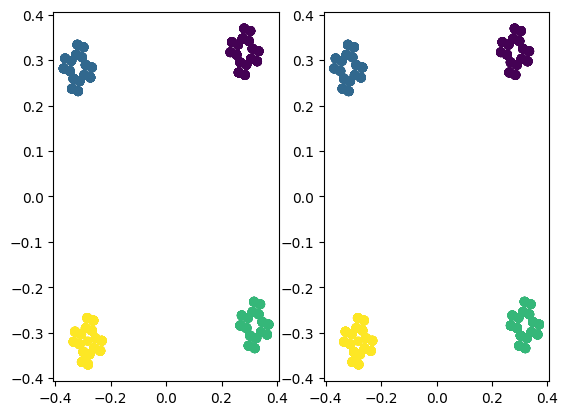

In [49]:
#Demodulating Signal
bbRx = comm.downconvert(pbRx, int(samplingRate/symbolRate),carrierFreq,samplingRate)
rxSymbols = demodulate(bbRx,psk)
print(comm.ber(comm.sym2bi(rxSymbols,m),comm.sym2bi(symbols,m)))
plotBaseBandData(bbRx,symbols,rxSymbols)

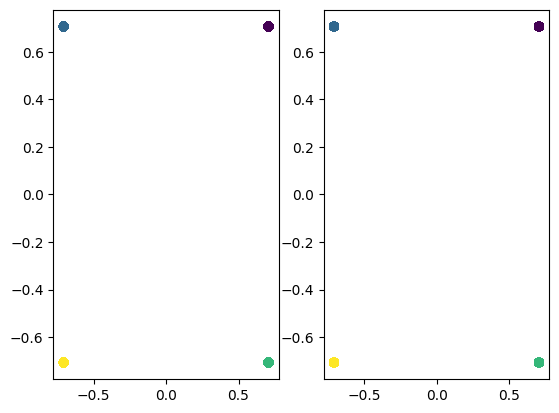

In [50]:
plotBaseBandData(bb1,symbols,symbols)

0.0


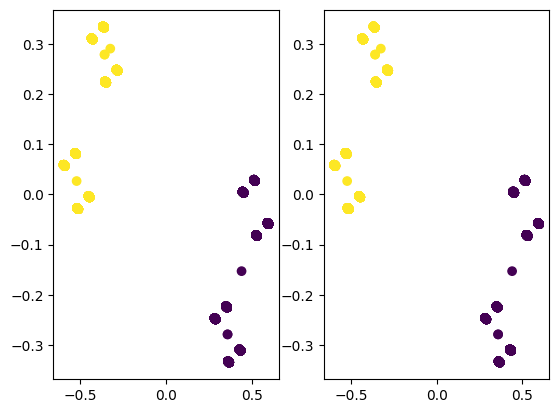

In [16]:
#Demodulating Signal
bbRx = demodulate2()
rxSymbols = demodulate(bbRx,psk)
print(comm.ber(comm.sym2bi(rxSymbols,m),comm.sym2bi(symbols,m)))
plotBaseBandData(bbRx,symbols,rxSymbols)

In [21]:
xyz()

579.6059649015699


In [23]:
bbRx[0].real

0.44013063668187735

In [24]:
579.6059649015699/0.44013063668187735

1316.895295613116

In [53]:
pb[1250:1250*2] , pb[1250*2:1250*3]

(array([ 21.17448935,  -1.38561666, -18.2906606 , ...,  -6.25297305,
         20.5446606 ,   3.63961666]),
 array([-18.92048935,   3.63961666,  20.5446606 , ...,   8.50697305,
        -18.2906606 ,  -1.38561666]))

1250.0

_______________________________DEMOD CONST__________________________________________________________________
____________________________________________________________________________________________________________
Range: 50.0
BER: 0.0


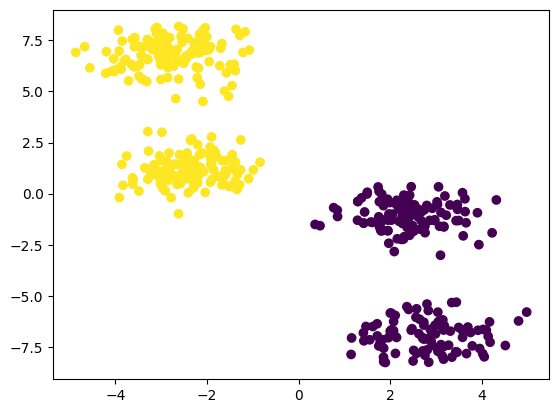

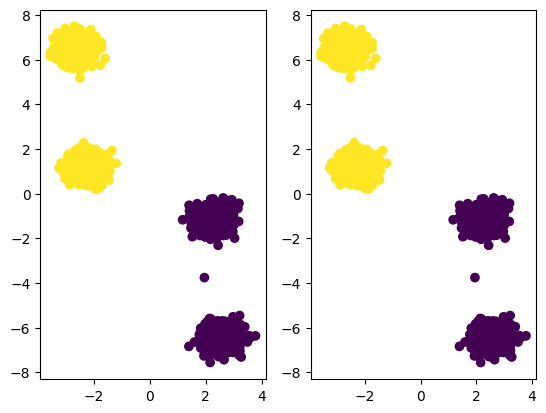

_______________________________DEMOD CONST__________________________________________________________________
____________________________________________________________________________________________________________
Range: 64.28571428571429
BER: 0.0


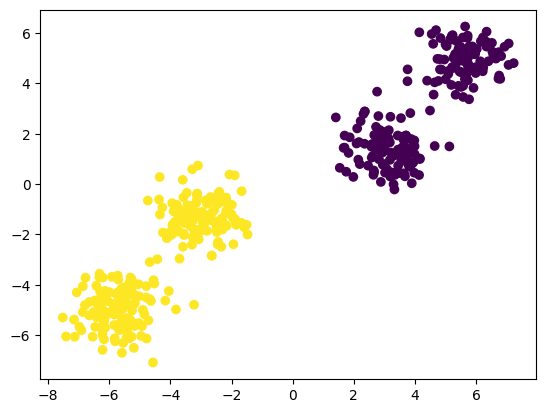

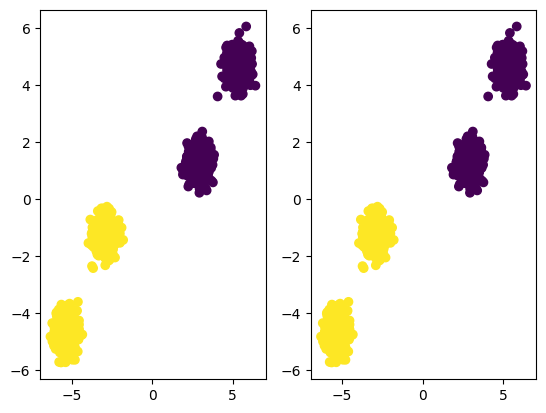

_______________________________DEMOD CONST__________________________________________________________________
____________________________________________________________________________________________________________
Range: 78.57142857142857
BER: 0.0


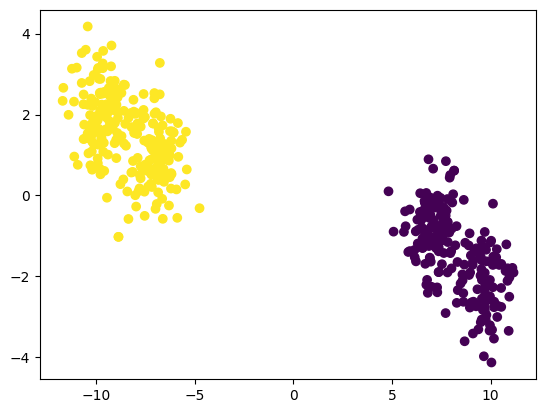

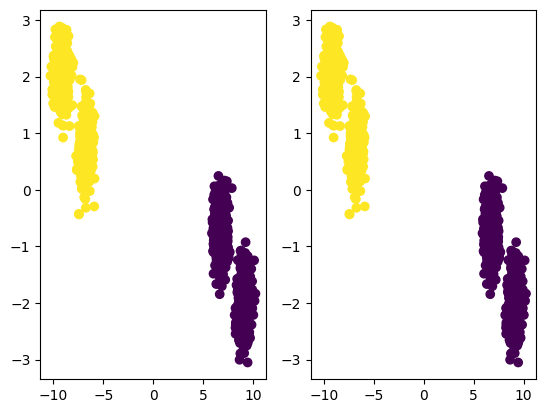

_______________________________DEMOD CONST__________________________________________________________________
____________________________________________________________________________________________________________
Range: 92.85714285714286
BER: 0.0


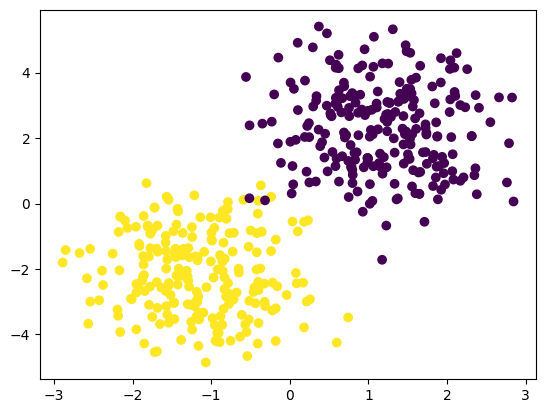

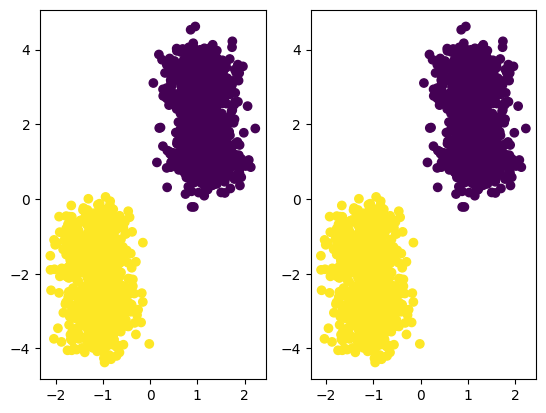

_______________________________DEMOD CONST__________________________________________________________________
____________________________________________________________________________________________________________
Range: 107.14285714285714
BER: 0.0


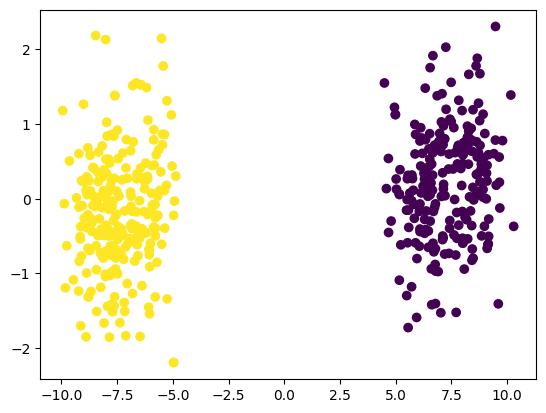

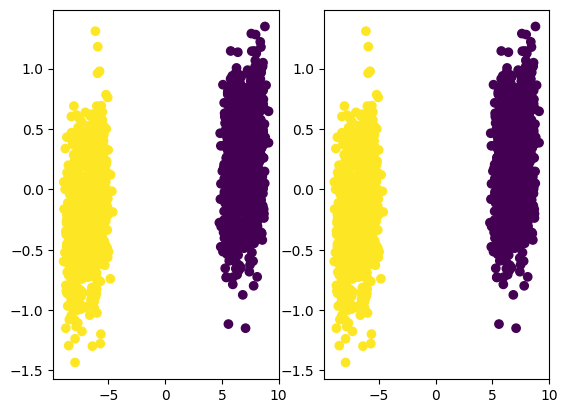

_______________________________DEMOD CONST__________________________________________________________________
____________________________________________________________________________________________________________
Range: 121.42857142857143
BER: 0.0


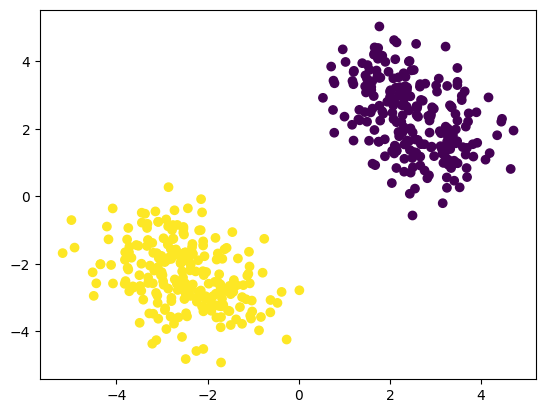

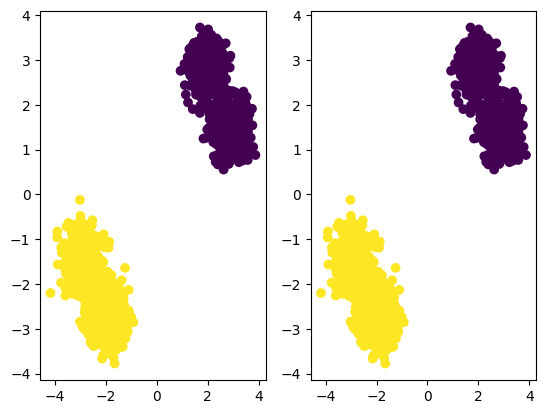

_______________________________DEMOD CONST__________________________________________________________________
____________________________________________________________________________________________________________
Range: 135.71428571428572
BER: 0.0


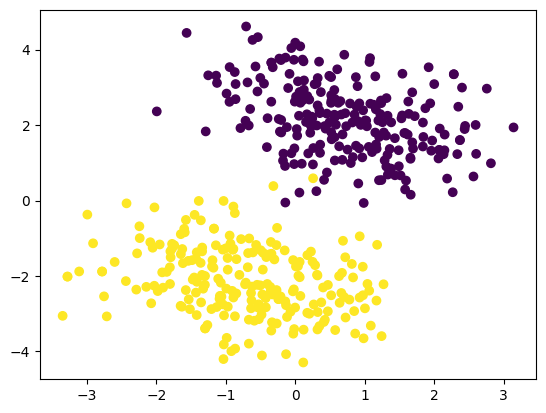

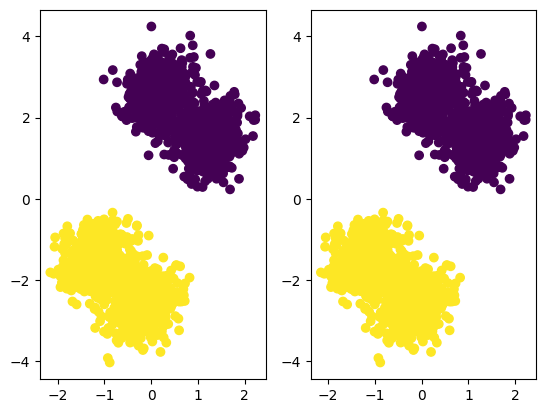

_______________________________DEMOD CONST__________________________________________________________________
____________________________________________________________________________________________________________
Range: 150.0
BER: 0.0


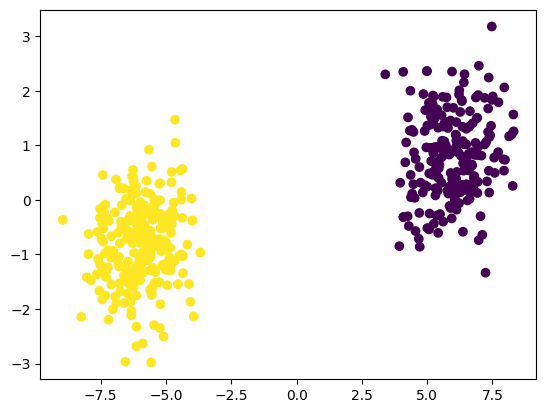

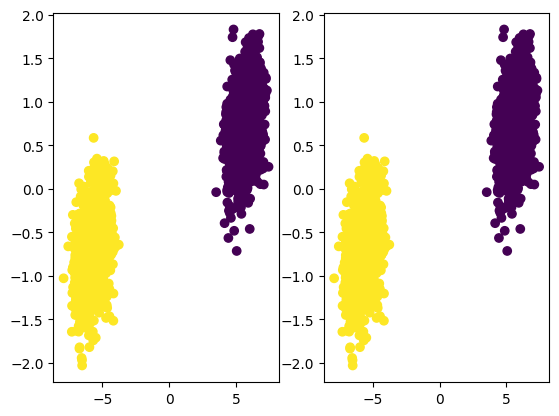

Average BER: 0.0


In [38]:
#With Training, Shallow Water
plotDiffData2(50,150,8)

In [25]:
t = np.linspace(0,1/bitRate,samplingRate//bitRate)
print(np.convolve(pbRx[0:1250],np.cos(2*np.pi*27000*t)).max())

579.6059649015699


In [34]:
t = np.linspace(0,1/bitRate,samplingRate//bitRate)
k = np.convolve(pbRx[1250:1250*2],np.cos(2*np.pi*27000*t))

In [28]:
bbRx[0]

(0.44013063668187735-0.152914798497958j)

In [29]:
bbRx[1]

(-0.35860137933407515+0.2790419285670378j)

In [32]:
np.sum(pbRx[1250:1250*2]*np.cos(2*np.pi*27000*t))

-448.2517241675939

In [35]:
for i in k:
    print(i)

-0.0622731199971896
1.0333785701589275
-0.2644180974539341
-1.9677247214965032
1.0788387202246954
2.616548844594881
-2.288800903553394
-2.8216932936307204
3.747521477141001
2.470805484045543
-5.267386889045797
-1.5107821182023895
6.6379013085533245
-0.04407005750470175
-7.646294742482706
2.1099794017193982
8.099022423256441
-4.53807915719898
-7.84228268534207
7.124984671878535
6.779727680463935
-9.628834925370754
-4.885737562928234
11.789581010864328
2.2129605942443056
-13.35191994140168
1.1067352840394606
14.089009484825375
-4.868232635822209
-13.82498137875087
8.805829986029648
12.454308119365333
-12.611821032852719
-9.95627259538556
15.95969926518843
6.403128189101303
-18.530281511759483
-1.9609963632190954
20.038748998313125
-3.1169037110616973
-20.260458404163757
8.504503511042076
19.05339304502835
-13.823822936451473
-16.375308386499047
18.671253036518404
12.29396678087295
-22.647369661353054
-6.9893317431740245
25.38811886273256
0.7471697232436116
-26.595023742991604
6.055853755

In [38]:
k[1252]

489.50066364890193

In [43]:
k = np.convolve(pbRx,np.cos(2*np.pi*27000*t))
k = k[0:len(pbRx)]

In [48]:
k[1250]

259.10642189888745

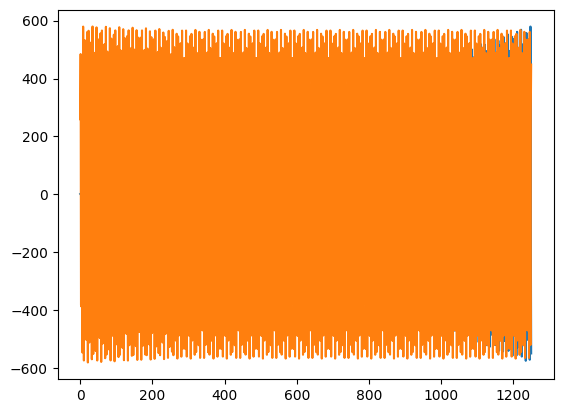

In [51]:
ploot.plot(k[0:1250])
ploot.plot(k[1250:1250*2])

In [53]:
pb

array([ 21.17448935,  -1.38561666, -18.2906606 , ...,   8.50697305,
       -18.2906606 ,  -1.38561667])

In [57]:
pbtmp = np.zeros(len(pb2)+1250)

In [58]:
pbtmp[625:625+len(pb)] = pb2

In [59]:
rxAmpDB = 20
#Received Signal
pbRx = np.convolve(pbtmp,abs(ir)[0:int(0.1*100000)])
pbRx = pbRx[:len(pbtmp)]
#pbRx = pbRx + noise(100000,len(pb),3.6,0.1)
#pbRx = generateUAN(pbRx,samplingRate,3.6,20)
#pbRx = comm.awgn(pbRx,20)
#Power Amplification

pbRx = pbRx * (10**(rxAmpDB//20))

0.0


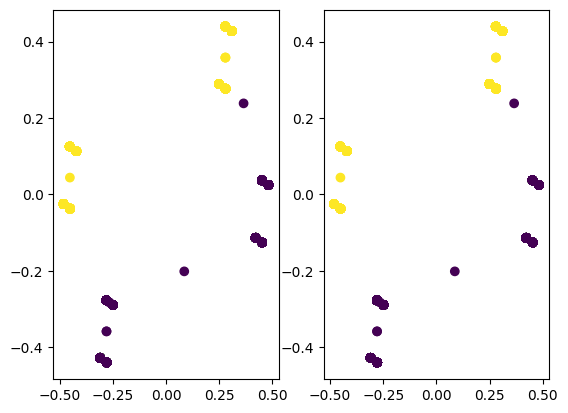

In [72]:
bbtmp = demodulate2()
rxSymbols = demodulate(bbtmp,psk)
print(comm.ber(comm.sym2bi(rxSymbols[1:2001],m),comm.sym2bi(symbols,m)))
plotBaseBandData(bbtmp,symbols,rxSymbols[1:2001])

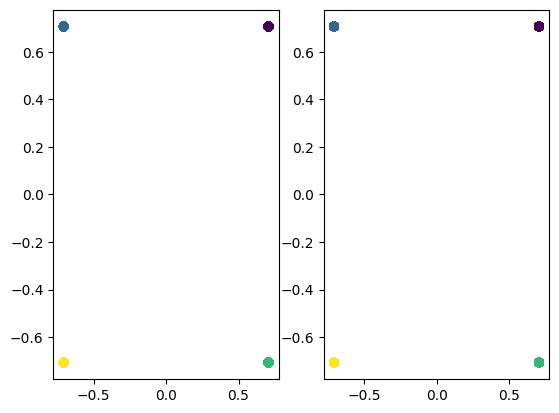

In [65]:
plotBaseBandData(bb1,symbols,rxSymbols)

In [41]:
!jupyter nbconvert --to html equalizer.ipynb

[NbConvertApp] Converting notebook equalizer.ipynb to html
[NbConvertApp] Writing 5978992 bytes to equalizer.html
